# Probe Training and Evaluation

In [ ]:
%%capture
# If getting 'Could not find project LASR_probe_gen' get key from https://wandb.ai/authorize and paste below
import wandb
wandb.login(key="")

## Do probe training

Load the activations and labels from HF, aggregate, and construct datasets to train the probe on (note sklearn doesn't require a validation dataset). Create a probe and fit it.

In [ ]:
import probe_gen.probes as probes
from sklearn.metrics import classification_report
from probe_gen.config import ConfigDict

# Load the best hyperparameters or set your own
probe_type = "mean"
dataset_name = "refusal_llama_3b_5k"
cfg = ConfigDict.from_json(probe_type, dataset_name)
# cfg = ConfigDict(layer=12, use_bias=True, normalize=True, c=0.001)

# Create train, val, and test datasets
activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer(dataset_name, layer=cfg.layer, verbose=True)
if probe_type == "mean":
    activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, splits=[3500, 500, 0], verbose=True)

# Initialise and fit a probe with the datasets
if probe_type == "mean_torch":
    probe = probes.TorchLinearProbe(cfg)
elif probe_type == "attention_torch":
    probe = probes.TorchAttentionProbe(cfg)
probe.fit(train_dataset, val_dataset)

# Print val results
eval_dict, y_pred, y_pred_proba = probe.eval(val_dataset)
print('\nroc_auc:', eval_dict['roc_auc'])

Evaluate the probe on test dataset.

In [ ]:
# Eval against seperate test datasets
for new_dataset_name in ["refusal_llama_3b_1k", "refusal_llama_3b_prompted_1k", "refusal_ministral_8b_1k"]:
    print(f"\nEvaluating on {new_dataset_name}")
    activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer(new_dataset_name, layer=cfg.layer, verbose=True)
    if probe_type == "mean":
        activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
    _, _, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, splits=[0, 0, 1000], verbose=True)

    # Evaluate the model
    eval_dict, y_pred, y_pred_proba = probe.eval(test_dataset)
    print(eval_dict)
    print(classification_report(test_dataset['y'], y_pred))

Nice visualisation to see how the probe splits the two classes

In [ ]:
from probe_gen.standard_experiments.experiment_plotting import plot_per_class_prediction_distributions

plot_per_class_prediction_distributions(test_dataset['y'], y_pred_proba)

## Hyperparameter Search

In [2]:
from probe_gen.standard_experiments.hyperparameter_search import run_full_hyp_search_on_layers
from probe_gen.standard_experiments.hyperparameter_search import load_best_params_from_search
from probe_gen.config import ConfigDict

probe_type = "mean"
dataset_name = "jailbreaks_llama_3b_5k"
model_name = "llama_3b"

# You might not be able to run all layers at once, so can do them in batches like below
layer_list = [6,9,12,15,18,21]
run_full_hyp_search_on_layers(
    probe_type, dataset_name, model_name, layer_list
)
# Can load the best params from the search at any time
cfg_dict = load_best_params_from_search(
    probe_type, dataset_name, model_name, layer_list
)
# Should add them to the local json if havent already
cfg = ConfigDict(cfg_dict)
cfg.add_to_json(probe_type, dataset_name)


######################### Evaluating layer 6 #############################
3302 3302 3302


ValueError: Splits must be a list of 3 numbers that sum to less than or equal to number of samples

## Testing On-Off Probes

In [4]:
from probe_gen.config import ConfigDict

# Specify rows of probes and columns of tests
test_dataset_names = [
    'sycophancy_llama_3b_1k',
    'sycophancy_llama_3b_prompted_1k',
    "sycophancy_qwen_3b_1k"
]
probes_setup = [
    ['mean', 'sycophancy_llama_3b_5k'],
    ['mean', 'sycophancy_llama_3b_prompted_5k'],
    ['mean', 'sycophancy_qwen_3b_5k']
]

# Can specify hyperparameters for each row if dont want to load best hyperparameters, can also do a mix of specified and not specified
# probes_setup = [
#     ['mean', 'refusal_llama_3b_5k', ConfigDict(layer=12, use_bias=False, normalize=True, c=0.001)],
#     ['mean', 'refusal_llama_3b_prompted_5k'],
#     ['mean', 'refusal_ministral_8b_5k', ConfigDict(layer=12, use_bias=False, normalize=True, c=0.001)]
# ]

print(probes_setup)

[['mean', 'sycophancy_llama_3b_5k'], ['mean', 'sycophancy_llama_3b_prompted_5k'], ['mean', 'sycophancy_qwen_3b_5k']]


In [ ]:
from probe_gen.standard_experiments.grid_experiments import run_grid_experiment_lean

run_grid_experiment_lean(probes_setup, test_dataset_names, "llama_3b")

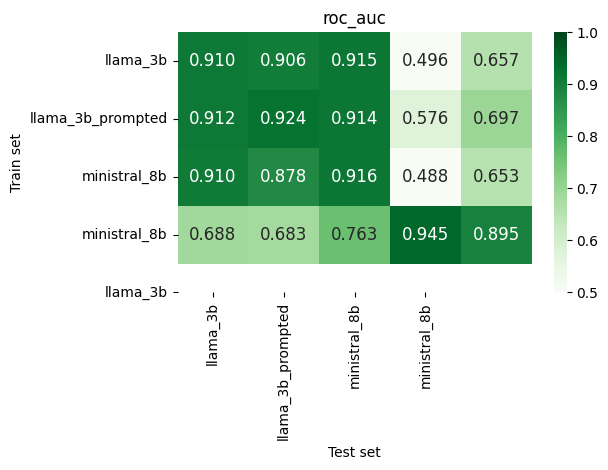

In [ ]:
from probe_gen.standard_experiments.grid_experiments import plot_grid_experiment_lean

plot_grid_experiment_lean(probes_setup, test_dataset_names, "llama_3b", metric="roc_auc")

In [ ]:
from probe_gen.standard_experiments.grid_experiments import plot_grid_experiment_lean_with_means
from probe_gen.config import TRAIN_AND_TEST_SETS

behaviour = ['refusal', 'lists', 'metaphors', 'science','sycophancy_short', 'sycophancy'][5]
test_dataset_names = TRAIN_AND_TEST_SETS[behaviour]['test']
probes_setup = [['mean', train_set] for train_set in TRAIN_AND_TEST_SETS[behaviour]['train']]


plot_grid_experiment_lean_with_means(probes_setup, test_dataset_names, "llama_3b", metric="roc_auc", behaviour=behaviour, save=True)

# Old code:

In [ ]:
from probe_gen.standard_experiments.grid_experiments import run_grid_experiment

run_grid_experiment(
    ['refusal_llama_3b_5k', 'refusal_llama_3b_prompted_5k', "refusal_ministral_8b_5k"], 
    ['refusal_llama_3b_1k', 'refusal_llama_3b_prompted_1k', "refusal_ministral_8b_1k"], 
    [12, 12, 12], # layer
    [False, False, False], # use_bias   (one for each row)
    [True, True, True], # normalize
    [0.001, 0.001, 0.001], # C
    "llama_3b"
)

In [ ]:
from probe_gen.standard_experiments.grid_experiments import plot_grid_experiment

plot_grid_experiment(
    ['refusal_llama_3b_5k', 'refusal_llama_3b_prompted_5k', "refusal_ministral_8b_5k"],  
    ['refusal_llama_3b_1k', 'refusal_llama_3b_prompted_1k', "refusal_ministral_8b_1k"], 
    ['On (llama)', 'On (llama prompted)', 'Off (ministral)'],
    ['On (llama)', 'On (llama prompted)', 'Off (ministral)'],
    [12, 12, 12], # layer
    [False, False, False], # use_bias   (one for each row)
    [True, True, True], # normalize
    [0.001, 0.001, 0.001], # C
    "llama_3b",
    "roc_auc"
)

In [ ]:
from probe_gen.standard_experiments.experiment_plotting import plot_results_table

plot_results_table(['refusal_5k_on', 'refusal_5k_off_other_model'], 12, 'mean', True, False, 'accuracy')

## Layer experiments

In [ ]:
from probe_gen.standard_experiments.layer_experiments import run_layer_experiments

use_bias = True
normalize_inputs = True

run_layer_experiments(
    "mean",
    "lists_llama_3b_story_5k",
    "llama_3b",
    1.0, # C
    [6, 9, 12, 15, 18], 
    use_bias_options=[True, False], 
    normalize_options=[True, False], 
)

In [2]:
from probe_gen.standard_experiments.experiment_plotting import plot_layer_experiment

plot_layer_experiment([6, 9, 12, 15, 18], 'lists_llama_3b_story_5k')

AttributeError: module 'matplotlib' has no attribute 'rcParams'

## Compare probe directions

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import probe_gen.probes as probes
from sklearn.metrics import classification_report
from probe_gen.config import ConfigDict

# dataset_list = ['refusal_llama_3b_5k', 'refusal_llama_3b_prompted_5k', 'refusal_ministral_8b_5k']
# layer_list = [12, 12, 12]
# use_bias_list = [False, False, False]
# normalize_list = [True, True, True]
# C_list = [0.001, 0.001, 0.001]

dataset_list = ['lists_llama_3b_5k', 'lists_llama_3b_prompted_5k', 'lists_qwen_3b_5k']
layer_list = [9, 12, 12]
use_bias_list = [True, True, False]
normalize_list = [False, False, False]
C_list = [1, 10, 1]

# dataset_list = ['metaphors_llama_3b_5k', 'metaphors_llama_3b_prompted_5k', 'metaphors_qwen_3b_5k']
# layer_list = [9, 15, 6]
# use_bias_list = [False, False, True]
# normalize_list = [False, False, False]
# C_list = [1, 1, 1]

probes_list = []

for i in range(len(dataset_list)):
    activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer(dataset_list[i], layer_list[i], verbose=True)
    activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
    # Create train, val, and test datasets
    train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0.1, test_size=0.2, verbose=True)

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=use_bias_list[i], C=C_list[i], normalize=normalize_list[i]))
    probe.fit(train_dataset, val_dataset)
    probes_list.append(probe)

In [ ]:
weights = []
biases = []
for i in range(len(probes_list)):
    weights.append(probes_list[i].classifier.coef_.flatten())
    biases.append(probes_list[i].classifier.intercept_.flatten())

print(biases)

print(cosine_similarity([weights[0]], [weights[1]])[0, 0])
print(cosine_similarity([weights[0]], [weights[2]])[0, 0])
print(cosine_similarity([weights[1]], [weights[2]])[0, 0])

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import probe_gen.probes as probes
from sklearn.metrics import classification_report
from probe_gen.config import ConfigDict

weights_list = []
for i in range(5):
    activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("refusal_llama_3b_5k", 12, verbose=True)
    activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
    # Create train, val, and test datasets
    train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0.1, test_size=0.2, balance=True, verbose=True)

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=False, C=0.001, normalize=True))
    probe.fit(train_dataset, val_dataset)
    weights = probe.classifier.coef_
    weights_list.append(weights)

In [ ]:
weights = np.concatenate(weights_list, axis=0)
print(weights.var(axis=0))

## OLD CODE

In [ ]:
# Generate fake graph
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Create the heatmap with seaborn
sns.heatmap(
    [[0.97,0.924,0.969,0.626], [0.966,0.932,0.96,0.635], [0.968,0.922,0.97,0.6], [0.33,0.345,0.449,0.511]], 
    xticklabels=['Natural', 'Prompted', 'Other Model', 'Stories'],
    yticklabels=['Natural', 'Prompted', 'Other Model', 'Stories'],
    annot=True,  # This adds the text annotations
    fmt='.2f',   # Format numbers to 3 decimal places
    cmap='Greens',  # You can change the colormap
    vmin=0.3,
    vmax=1,
    ax=ax,
    annot_kws={"size": 20}
)

# Rotate x-axis labels
#plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# Set labels and title
plt.xlabel('Test set', fontsize=14)
plt.ylabel('Train set', fontsize=14)
ax.set_title("Probe (AUROC) Classification of Lists Behaviour in Llama 3B", fontsize=15)

# increase graph size
fig.set_size_inches(8, 6)
# fig.tight_layout()
plt.show()


In [ ]:
import probe_gen.probes as probes
from sklearn.metrics import classification_report


activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("refusal_5k_on", 12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
# Create train, val, and test datasets
train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True, verbose=True)


In [ ]:
from probe_gen.config import ConfigDict

C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
evals_norm_true_bias_true = []
evals_norm_true_bias_false = []
evals_norm_false_bias_true = []
evals_norm_false_bias_false = []

for C in C_values:
    print(f"############ {C} #############")

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=True, C=C, normalize=True))
    probe.fit(train_dataset, val_dataset)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_true_bias_true.append(eval_dict)

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=False, C=C, normalize=True))
    probe.fit(train_dataset, val_dataset)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_true_bias_false.append(eval_dict)

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=True, C=C, normalize=False))
    probe.fit(train_dataset, val_dataset)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_false_bias_true.append(eval_dict)

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=False, C=C, normalize=False))
    probe.fit(train_dataset, val_dataset)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_false_bias_false.append(eval_dict)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract accuracy and ROC-AUC values for each configuration
def extract_metrics(results_list):
    accuracy = [result['accuracy'] for result in results_list]
    roc_auc = [result['roc_auc'] for result in results_list]
    return accuracy, roc_auc

# Extract metrics for all configurations
acc1, roc1 = extract_metrics(evals_norm_true_bias_true)
acc2, roc2 = extract_metrics(evals_norm_true_bias_false)
acc3, roc3 = extract_metrics(evals_norm_false_bias_true)
acc4, roc4 = extract_metrics(evals_norm_false_bias_false)

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define labels for each configuration (modify these based on your actual hyperparameter combinations)
config_labels = [
    'normalize=True, use_bias=True',  # Replace with actual hyperparameter values, e.g., 'penalty=l2, solver=lbfgs'
    'normalize=True, use_bias=False',  # e.g., 'penalty=l2, solver=liblinear'
    'normalize=False, use_bias=True',  # e.g., 'penalty=l1, solver=liblinear'
    'normalize=False, use_bias=False'   # e.g., 'penalty=elasticnet, solver=saga'
]

# Plot accuracy (left subplot)
ax1.semilogx(C_values, acc1, marker='o', label=config_labels[0])
ax1.semilogx(C_values, acc2, marker='s', label=config_labels[1])
ax1.semilogx(C_values, acc3, marker='^', label=config_labels[2])
ax1.semilogx(C_values, acc4, marker='d', label=config_labels[3])

ax1.set_xlabel('C (Inverse Regularization Strength)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs C')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot ROC-AUC (right subplot)
ax2.semilogx(C_values, roc1, marker='o', label=config_labels[0])
ax2.semilogx(C_values, roc2, marker='s', label=config_labels[1])
ax2.semilogx(C_values, roc3, marker='^', label=config_labels[2])
ax2.semilogx(C_values, roc4, marker='d', label=config_labels[3])

ax2.set_xlabel('C (Inverse Regularization Strength)')
ax2.set_ylabel('ROC-AUC')
ax2.set_title('ROC-AUC vs C')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Optional: Find and print the best configuration for each metric
def find_best_config(metric_lists, config_labels, C_values):
    best_scores = []
    for i, metrics in enumerate(metric_lists):
        best_idx = np.argmax(metrics)
        best_scores.append({
            'config': config_labels[i],
            'best_C': C_values[best_idx],
            'best_score': metrics[best_idx]
        })
    return best_scores

# Find best configurations
accuracy_lists = [acc1, acc2, acc3, acc4]
roc_lists = [roc1, roc2, roc3, roc4]

print("Best Accuracy Results:")
best_acc = find_best_config(accuracy_lists, config_labels, C_values)
for result in best_acc:
    print(f"{result['config']}: C={result['best_C']}, Accuracy={result['best_score']:.4f}")

print("\nBest ROC-AUC Results:")
best_roc = find_best_config(roc_lists, config_labels, C_values)
for result in best_roc:
    print(f"{result['config']}: C={result['best_C']}, ROC-AUC={result['best_score']:.4f}")